In [1]:
#Importing required Libraries
import re
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RadarLab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RadarLab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#ML LIbraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [3]:
df=pd.read_csv('dataset.csv')

In [4]:
df.head()

page                                            comment  scale
0  Page_1  tento areal je v katastrofalnom stave aspon 10...     -2
1  Page_1  skoda len ze ponukaju aj stale tie iste a rovn...     -2
2  Page_1  Mali by ste dat tabulky "VSTUP DO BRATISLAVY N...     -2
3  Page_1  Za to, ako dlho sa to stavia, tam mala byt pos...     -2
4  Page_1  A kde je preboha nejaká zeleň ?????? 😞😞😕☹️☹️☹️...     -2

<AxesSubplot:xlabel='scale', ylabel='count'>

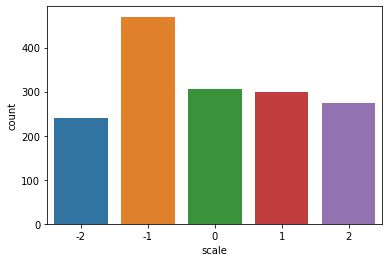

In [5]:
import seaborn as sns
sns.countplot(df['scale'])

In [6]:
#Since, the data in imbalanced, I've resampled it.
very_neg=df.where(df['scale']==-2)
neg=df.where(df['scale']==-1)
neut=df.where(df['scale']==0)
pos=df.where(df['scale']==1)
very_pos=df.where(df['scale']==2)

In [7]:
very_neg.dropna(inplace=True, axis=0)
neg.dropna(inplace=True, axis=0)
neut.dropna(inplace=True, axis=0)
pos.dropna(inplace=True, axis=0)
very_pos.dropna(inplace=True, axis=0)

In [8]:
very_neg.shape, neg.shape, neut.shape, pos.shape,very_pos.shape

((239, 3), (470, 3), (306, 3), (298, 3), (275, 3))

In [9]:
#neg2=neg.sample(frac=0.33, random_state=60)

In [10]:
df=pd.concat([very_neg,neg,neut,pos,very_pos], axis=0)

<AxesSubplot:xlabel='scale', ylabel='count'>

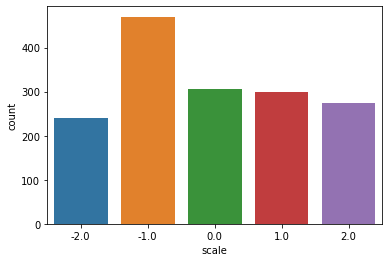

In [11]:
df=df.sample(frac=1, random_state=60)
sns.countplot(df['scale'])
#Data is now balanced

In [12]:
def process_comment(comment): #Created function to prcess a given comment #Deeplearning.ai
   
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    stopwords_slovak = stopwords.words('slovene')
    # remove stock market tickers like $GE
    comment = re.sub(r'\$\w*', '', comment)
    # remove old style retweet text "RT"
    comment = re.sub(r'^RT[\s]+', '', comment)
    # remove hyperlinks
    comment = re.sub(r'https?:\/\/.*[\r\n]*', '', comment)
    # remove hashtags
    # only removing the hash # sign from the word
    comment = re.sub(r'#', '', comment)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    comment_tokens = tokenizer.tokenize(comment)

    comments_clean = []
    for word in comment_tokens:
        if (word not in stopwords_slovak and  
                word not in string.punctuation):  
            stem_word = stemmer.stem(word) 
            lemm_word = lemmatizer.lemmatize(stem_word)
            comments_clean.append(lemm_word)

    return comments_clean


In [13]:
def build_freqs(comments, ys): #Created function to create a dectionary including a (word, sentiment) tuple with its frequency
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, comment in zip(yslist, comments):
        for word in process_comment(comment):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [14]:
df=df.drop('page', axis=1) #removing page column

In [15]:
df=df.set_index(np.arange(1, 1589)) #creating a series index column

In [16]:
comment=df['comment']
sentiment=df['scale']

In [17]:
#Splitting the data into train and test
train_x=comment[:1500]
train_y=sentiment[:1500]
test_x=comment[1500:]
test_y=sentiment[1500:]

In [18]:
test_x

1501    2 sa neoplati pokial nezarabate viac ako 1200€...
1502    Jej to je super video...aj my sme vo februari ...
1503    Doteraz ste za expresnú platbu faktúry v preda...
1504    My už dlhé roky triedime a snažíme sa minimali...
1505             Tento sa vam velmi vydaril Marketing 😃👏👍
                              ...                        
1584    A o dva roky stupnu sadzby na dvojnasobok a bu...
1585                 Tento je aspoň bez tej vašej chémie.
1586    Pretože výrobky z lidla sú výborné a určite st...
1587    mám Lenovo niekoľko rokov a som maximálne spok...
1588    prepactte ale tento spot sa neda pozerat cista...
Name: comment, Length: 88, dtype: object

In [19]:
print('Unprocessed Comment:',train_x[1])
process_comment(train_x[1]) #Example of process comment

Unprocessed Comment: Preto netreba poistku, lebo sú to vyhodené peniaze


['preto', 'netreba', 'poistku', 'lebo', 'sú', 'vyhodené', 'peniaz']

In [20]:
train_y[1]

-2.0

In [21]:
#Creating a list X of all the comments after processing them
X=[]
for i in range(1,len(train_x)):
  tokens = process_comment(train_x[i])
  X.append(tokens)
print(X) 


[['preto', 'netreba', 'poistku', 'lebo', 'sú', 'vyhodené', 'peniaz'], ['ten', 'hovor', 'mohol', 'byť', 'celkom', 'zaujímavý', 'a', 'podnetný', 'pre', 'strani', ':d'], ['pytalo', 'by', 'viac', 'moznosti', 'a', 'hlavn', 'okolo', 'trvaleho', 'prikazu', 'a', 'podobn', ':)', 'nech', 'sa', 'telefon', 'plnohodnotn', 'pracovat', 'ako', 'pocitaci', 'a', 'poriesit', 'vsetki', 'zalezitosti', ':)'], ['samsung', 'jako', 'kofola', '...', 'když', 'jej', 'miluješ', 'není', 'co', 'řešit', ':-)', 'kvalita'], ['teším', 'sa', 'vystupeni', 'df', 'getulata', '21.11', '2015'], ['nadhera', 'musel', 'byt', 'zazitok', ':)', 'blahozelam'], ['nadhera', 'hned', 'by', 'som', 'menila'], ['krásne', 'aj', 'by', 'som', 'brala', 'hoci', 'mám', 'peknú', 'kuchyňu'], ['poslednej', 'dobe', 'už', 'nie', 'toľko', 'ale', 'vianočné', 'pečeni', 'nenechajú', 'ujsť', ':-)'], ['mala', 'som', 'tu', 'cest', 'osobn', 'sa', 'stretnut', 'pani', 'zuzku', 'naozaj', 'uzasna', 'zena', 'a', 'klobuk', 'dole', 'prajem', 'jej', 'abi', 'sa', 'je

In [22]:

#Creating the Frequency dictionary
freq_dict = build_freqs(train_x, train_y)

# check the output
print("type(freq_dict) = " + str(type(freq_dict)))
print("len(freq_dict) = " + str(len(freq_dict.keys())))

type(freq_dict) = <class 'dict'>
len(freq_dict) = 13353


In [23]:
def extract_features(comment, freq_dict): 
#Creating a function that vectorizes every comment to the size (1x4) and appends it to create a matrix with m rows and 4 columns
#[bias, 2,1,0,-1,-2]

    # process_comment tokenizes, stems, and removes stopwords
    word_l = process_comment(comment)
    
    # 5 elements in the form of a 1 x 6 vector
    x = np.zeros((1, 6)) 
    
    #bias term is set to 1
    x[0,0] = 1 

    for word in word_l:
        
        # increment the word count for the very_positive label 2
        x[0,1] += freq_dict.get((word, 2.0),0) 
        # increment the word count for the positive label 1
        x[0,2] += freq_dict.get((word, 1.0),0)
        # increment the word count for the netural label 0
        x[0,3] += freq_dict.get((word, 0.0),0)
        # increment the word count for the negative label -1
        x[0,4] += freq_dict.get((word, -1.0),0)
         # increment the word count for the very_negative label -2
        x[0,5] += freq_dict.get((word, -2.0),0)

    assert(x.shape == (1, 6))
    return x

In [24]:
#Creating the matrix with comment vectors
X = np.zeros((len(train_x), 6))
for i in range(1,len(train_x)):
    X[i, :]= extract_features(train_x[i], freq_dict)

# training labels corresponding to X
Y = train_y

In [25]:
logit=LogisticRegression()
logit.fit(X,Y)
print(logit.score(X,Y))
scores=cross_val_score(logit, X,Y, scoring='f1_macro', cv=10)
print(scores)
np.mean(scores)

0.28
[0.16453379 0.16093074 0.13816385 0.12533333 0.18779918 0.14933333
 0.15334733 0.1247768  0.1855763  0.1148374 ]


0.1504632044691296

**The Accuracy is very low, trying n-gram models and inbuilt vectorizers**

In [26]:
count_vectorizer = CountVectorizer(min_df=2, max_df=0.96, ngram_range=(1,2))
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.96, ngram_range=(1,2))
hash_vectorizer = HashingVectorizer(ngram_range=(1,2))

In [27]:
x_cv = count_vectorizer.fit_transform(train_x)
x_tv = tfidf_vectorizer.fit_transform(train_x)
x_hv = hash_vectorizer.fit_transform(train_x)
xt_cv = count_vectorizer.transform(test_x)
xt_tv = tfidf_vectorizer.transform(test_x)
xt_hv = hash_vectorizer.transform(test_x)


In [28]:
#Bigram Count Vectorizer LOGISTIC
logit=LogisticRegression(C=0.5, multi_class='auto', solver='liblinear', penalty='l1',random_state=6)
logit.fit(x_cv, train_y)
pred_logit=logit.predict(xt_cv)
f1_score(test_y, pred_logit, average='macro')

0.23835155127591098

In [29]:
#Bigram Tfidf Vectorizer LOGISTIC
logit=LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs', penalty='l2',random_state=6)
logit.fit(x_tv, train_y)
pred_logit=logit.predict(xt_tv)
f1_score(test_y, pred_logit, average='macro')

0.30487622217599336

In [30]:
#Bigram Hashing Vectorizer LOGISTIC  Code is too slow
logit=LogisticRegression(C=1, multi_class='auto', solver='lbfgs', penalty='l2',random_state=6)
logit.fit(x_hv, train_y)
pred_logit=logit.predict(xt_hv)
f1_score(test_y, pred_logit, average='macro')

0.2408963585434174

**Thus, CountVectorizer performs better than Tfidf and Hashing Vectorizer in this case**

In [31]:
xgb=XGBClassifier(max_depth=8, learning_rate=0.5, n_estimators=120, objective='multi:softmax', min_child_weight=0.6, max_delta_step=5, reg_lambda=1)
xgb.fit(x_cv, train_y)
pred=xgb.predict(xt_cv)
f1_score(test_y, pred, average='macro')

[06:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3400534339474432

In [32]:
#Bigram Tfidf Vectorizer XGB
xgb=XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=150, objective='multi:softmax', num_class=5, random_state=6)
xgb.fit(x_tv, train_y)
pred=xgb.predict(xt_tv)
f1_score(test_y, pred, average='macro')

[06:48:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.24256664388243335

In [33]:
#Bigram Hashing Vectorizer XGB   Code takes very long to converge and fails to run
xgb=XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=150, objective='multi:softmax', num_class=5, random_state=6)
xgb.fit(x_hv, train_y)
pred=xgb.predict(xt_hv)
f1_score(test_y, pred, average='macro')

[06:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.2815404525340236

**For XGBoost Classifier also, CountVectorizer performed better than TfidfVectorizer**

In [34]:
#Bigram Count Vectorizer Naive
naive= MultinomialNB(alpha=1)
naive.fit(x_cv, train_y)
pred=naive.predict(xt_cv)
f1_score(test_y, pred, average='macro')

0.44056056056056053

In [ ]:
#Bigram Tfidf Vectorizer Naive
naive= MultinomialNB(alpha=1)
naive.fit(x_tv, train_y)
pred=naive.predict(xt_cv)
f1_score(test_y, pred, average='macro')

In [ ]:
#Gridsearch Logistic
param_grid = {'multi_class': ['auto','multinomial'], 'C':[0.01,0.05,0.1,0.5,1], 'solver':['lbfgs', 'saga', 'sag'], 'penalty':['l1','l2']}
grid_logit = GridSearchCV(LogisticRegression(), param_grid, scoring='f1_macro', cv=10)
grid_logit.fit(x_cv,y_train)
print(grid_logit.best_params_)
print(grid_logit.best_score_)

In [ ]:
#GridSearch XGBoost
param_grid = {'max_depth': [3,6,9], 'objective':['multi:softmax'], 'learning_rate':[0.01,0.05,0.1,0.5,1], 'n_estimators':[50,75,100], 'reg_lambda':[0.1,1,10]}
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, scoring='f1_macro', cv=5)
grid_xgb.fit(x_cv,y_train)
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

In [ ]:
test=pd.read_csv('test.csv')

In [ ]:
test.head()

In [ ]:
xt_cv = count_vectorizer.transform(test['text']) #Vectorizing Test Data

In [ ]:
test['Target'] = logit.predict(xt_cv) #Using Logistic Regression to Predict 

In [ ]:
test.head()

In [ ]:
test=test.drop('text',axis=1)

In [ ]:
test.head()

In [ ]:
test.to_csv('Predictions.csv')

In [ ]:
from google.colab import files
files.download('Predictions.csv')